In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.9 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torcheval.metrics import R2Score
from datetime import datetime
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import joblib
import timm
from torch.optim import lr_scheduler
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from xgboost import XGBRegressor


In [3]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [4]:
ANCILLARY = ["WORLDCLIM_BIO1_annual_mean_temperature","WORLDCLIM_BIO12_annual_precipitation","WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month","WORLDCLIM_BIO15_precipitation_seasonality","WORLDCLIM_BIO4_temperature_seasonality","WORLDCLIM_BIO7_temperature_annual_range","SOIL_bdod_0.5cm_mean_0.01_deg","SOIL_bdod_100.200cm_mean_0.01_deg","SOIL_bdod_15.30cm_mean_0.01_deg","SOIL_bdod_30.60cm_mean_0.01_deg","SOIL_bdod_5.15cm_mean_0.01_deg","SOIL_bdod_60.100cm_mean_0.01_deg","SOIL_cec_0.5cm_mean_0.01_deg","SOIL_cec_100.200cm_mean_0.01_deg","SOIL_cec_15.30cm_mean_0.01_deg","SOIL_cec_30.60cm_mean_0.01_deg","SOIL_cec_5.15cm_mean_0.01_deg","SOIL_cec_60.100cm_mean_0.01_deg","SOIL_cfvo_0.5cm_mean_0.01_deg","SOIL_cfvo_100.200cm_mean_0.01_deg","SOIL_cfvo_15.30cm_mean_0.01_deg","SOIL_cfvo_30.60cm_mean_0.01_deg","SOIL_cfvo_5.15cm_mean_0.01_deg","SOIL_cfvo_60.100cm_mean_0.01_deg","SOIL_clay_0.5cm_mean_0.01_deg","SOIL_clay_100.200cm_mean_0.01_deg","SOIL_clay_15.30cm_mean_0.01_deg","SOIL_clay_30.60cm_mean_0.01_deg","SOIL_clay_5.15cm_mean_0.01_deg","SOIL_clay_60.100cm_mean_0.01_deg","SOIL_nitrogen_0.5cm_mean_0.01_deg","SOIL_nitrogen_100.200cm_mean_0.01_deg","SOIL_nitrogen_15.30cm_mean_0.01_deg","SOIL_nitrogen_30.60cm_mean_0.01_deg","SOIL_nitrogen_5.15cm_mean_0.01_deg","SOIL_nitrogen_60.100cm_mean_0.01_deg","SOIL_ocd_0.5cm_mean_0.01_deg","SOIL_ocd_100.200cm_mean_0.01_deg","SOIL_ocd_15.30cm_mean_0.01_deg","SOIL_ocd_30.60cm_mean_0.01_deg","SOIL_ocd_5.15cm_mean_0.01_deg","SOIL_ocd_60.100cm_mean_0.01_deg","SOIL_ocs_0.30cm_mean_0.01_deg","SOIL_phh2o_0.5cm_mean_0.01_deg","SOIL_phh2o_100.200cm_mean_0.01_deg","SOIL_phh2o_15.30cm_mean_0.01_deg","SOIL_phh2o_30.60cm_mean_0.01_deg","SOIL_phh2o_5.15cm_mean_0.01_deg","SOIL_phh2o_60.100cm_mean_0.01_deg","SOIL_sand_0.5cm_mean_0.01_deg","SOIL_sand_100.200cm_mean_0.01_deg","SOIL_sand_15.30cm_mean_0.01_deg","SOIL_sand_30.60cm_mean_0.01_deg","SOIL_sand_5.15cm_mean_0.01_deg","SOIL_sand_60.100cm_mean_0.01_deg","SOIL_silt_0.5cm_mean_0.01_deg","SOIL_silt_100.200cm_mean_0.01_deg","SOIL_silt_15.30cm_mean_0.01_deg","SOIL_silt_30.60cm_mean_0.01_deg","SOIL_silt_5.15cm_mean_0.01_deg","SOIL_silt_60.100cm_mean_0.01_deg","SOIL_soc_0.5cm_mean_0.01_deg","SOIL_soc_100.200cm_mean_0.01_deg","SOIL_soc_15.30cm_mean_0.01_deg","SOIL_soc_30.60cm_mean_0.01_deg","SOIL_soc_5.15cm_mean_0.01_deg","SOIL_soc_60.100cm_mean_0.01_deg","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m3","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m3","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m3","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m3","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m4","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m4","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m5","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m5","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m5","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m6","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m6","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m6","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m7","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m7","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m7","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m7","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m8","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m8","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m8","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m8","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m8","MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m9","MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m9","MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m9","MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m9","MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m9","VOD_C_2002_2018_multiyear_mean_m01","VOD_C_2002_2018_multiyear_mean_m02","VOD_C_2002_2018_multiyear_mean_m03","VOD_C_2002_2018_multiyear_mean_m04","VOD_C_2002_2018_multiyear_mean_m05","VOD_C_2002_2018_multiyear_mean_m06","VOD_C_2002_2018_multiyear_mean_m07","VOD_C_2002_2018_multiyear_mean_m08","VOD_C_2002_2018_multiyear_mean_m09","VOD_C_2002_2018_multiyear_mean_m10","VOD_C_2002_2018_multiyear_mean_m11","VOD_C_2002_2018_multiyear_mean_m12","VOD_Ku_1987_2017_multiyear_mean_m01","VOD_Ku_1987_2017_multiyear_mean_m02","VOD_Ku_1987_2017_multiyear_mean_m03","VOD_Ku_1987_2017_multiyear_mean_m04","VOD_Ku_1987_2017_multiyear_mean_m05","VOD_Ku_1987_2017_multiyear_mean_m06","VOD_Ku_1987_2017_multiyear_mean_m07","VOD_Ku_1987_2017_multiyear_mean_m08","VOD_Ku_1987_2017_multiyear_mean_m09","VOD_Ku_1987_2017_multiyear_mean_m10","VOD_Ku_1987_2017_multiyear_mean_m11","VOD_Ku_1987_2017_multiyear_mean_m12","VOD_X_1997_2018_multiyear_mean_m01","VOD_X_1997_2018_multiyear_mean_m02","VOD_X_1997_2018_multiyear_mean_m03","VOD_X_1997_2018_multiyear_mean_m04","VOD_X_1997_2018_multiyear_mean_m05","VOD_X_1997_2018_multiyear_mean_m06","VOD_X_1997_2018_multiyear_mean_m07","VOD_X_1997_2018_multiyear_mean_m08","VOD_X_1997_2018_multiyear_mean_m09","VOD_X_1997_2018_multiyear_mean_m10","VOD_X_1997_2018_multiyear_mean_m11","VOD_X_1997_2018_multiyear_mean_m12"]
LABELS =  ["X4_mean", "X11_mean", "X18_mean", "X26_mean", "X50_mean", "X3112_mean"]
OUTPUTS = ["X4", "X11", "X18", "X26", "X50", "X3112"]

TRAIN_CSV = "/kaggle/input/cs-480-2024-spring/data/train.csv"
TRAIN_IMG = "/kaggle/input/cs-480-2024-spring/data/train_images"
TEST_CSV = "/kaggle/input/cs-480-2024-spring/data/test.csv"
TEST_IMG = "/kaggle/input/cs-480-2024-spring/data/test_images"

In [5]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# remove outliers
train_df_labels = np.log10(train_df.iloc[:, -6:]) # Select Labels and take log transform
train_df = train_df[(np.abs(stats.zscore(train_df_labels)) < 3).all(axis=1)] # Find Outliers


In [6]:
# split training and validation data
train_df_data = train_df.iloc[:, :-6]
train_df_labels = train_df.iloc[:, -6:]

x_train, x_val, y_train, y_val = train_test_split(train_df_data,train_df_labels,train_size=0.8,test_size=0.2)
#x_train, x_val, y_train, y_val = train_df_data, train_df_data, train_df_labels, train_df_labels

In [7]:
def min_max_scaler(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

def min_max_scaler_inverse(x, x_min, x_max):
    return x * (x_max - x_min) + x_min

In [8]:
# Save Training Transformation
train_label_min = y_train.min()
train_label_max = y_train.max()

# Transform Training Labels
y_train = min_max_scaler(np.log10(y_train), np.log10(train_label_min), np.log10(train_label_max))
# Transform Eval Labels
#y_val = min_max_scaler(np.log10(y_val), np.log10(train_label_min), np.log10(train_label_max))


In [9]:
# Split Image Ids
id_train = x_train.iloc[:, 0]
x_train = x_train.iloc[:, 1:]

id_val = x_val.iloc[:, 0]
x_val = x_val.iloc[:, 1:]


train_data_max = x_train.max()
train_data_min = x_train.min()

# Transform Training Data
x_train = min_max_scaler(x_train, train_data_min, train_data_max)

# Transform Eval Data
x_val = min_max_scaler(x_val, train_data_min, train_data_max)

In [10]:
mean = [0.44636952, 0.45045866, 0.33603755]
std = [0.18342973, 0.17943772, 0.17788026]

In [11]:
test_df = pd.read_csv(TEST_CSV)
id_test = test_df.iloc[:, 0]
x_test = test_df.iloc[:, 1:]
# Scale Correctly
x_test = min_max_scaler(x_test, train_data_min, train_data_max)


In [12]:
class CustomDataset(Dataset):
    def __init__(self, train, df_id, df_ancillary, df_labels, img_dir, image_transform=None):
        self.train = train
        self.df_id = df_id
        self.df_ancillary = df_ancillary.astype('float32')
        self.df_labels = None
        if self.train:
            self.df_labels = df_labels.astype('float32')
        self.img_dir = img_dir
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df_ancillary)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        id_num = self.df_id.iloc[idx]
        
        img_name = os.path.join(self.img_dir, str(id_num) + ".jpeg")
        image = Image.open(img_name)
        if self.image_transform:
            image = self.image_transform(image)
            
        ancillary = self.df_ancillary.iloc[idx, :].to_numpy()
        
        label = None
        if self.train:
            label = self.df_labels.iloc[idx, :].to_numpy()
            return (image, ancillary, label, id_num)
        else:
            return (image, ancillary, id_num)

In [13]:
class ClampTransform(torch.nn.Module):
    def forward(self, img):
        return torch.clamp(img, min=0, max=1)
    
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    ClampTransform(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])
print(x_train.shape)
training_data = CustomDataset(True, id_train, x_train, y_train, TRAIN_IMG, image_transform)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=False)

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])
validation_data = CustomDataset(True, id_val, x_val, y_val, TRAIN_IMG, image_transform)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=False)

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std),
])
testing_data = CustomDataset(False, id_test, x_test, None, TEST_IMG, image_transform)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=False)


(31644, 163)


In [14]:
print(len(training_loader))

495


In [15]:
model = timm.create_model(
            'tf_efficientnetv2_b1.in1k',
            pretrained=True,
            num_classes=0
        )
model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()
predictions = torch.empty((0,1280))
predictions = predictions.to(device)
with torch.no_grad():
    for image, ancillary, label, _ in training_loader:
        image, ancillary = image.to(device), ancillary.to(device)
        outputs = model(image)
        predictions = torch.cat((predictions, outputs))
predictions = predictions.cpu().numpy()
predictions = pd.DataFrame(predictions)
x_train.reset_index(drop=True, inplace=True)
predictions.reset_index(drop=True, inplace=True)
x_train = pd.concat([x_train, predictions], axis=1)


model.safetensors:   0%|          | 0.00/32.9M [00:00<?, ?B/s]

In [16]:
predictions = torch.empty((0,1280))
predictions = predictions.to(device)
with torch.no_grad():
    for image, ancillary, label, _ in validation_loader:
        image, ancillary = image.to(device), ancillary.to(device)
        outputs = model(image)
        predictions = torch.cat((predictions, outputs))
predictions = predictions.cpu().numpy()
predictions = pd.DataFrame(predictions)
x_val.reset_index(drop=True, inplace=True)
predictions.reset_index(drop=True, inplace=True)
x_val = pd.concat([x_val, predictions], axis=1)

In [17]:
predictions = torch.empty((0,1280))
predictions = predictions.to(device)
with torch.no_grad():
    for image, ancillary, id_num in testing_loader:
        image, ancillary = image.to(device), ancillary.to(device)
        outputs = model(image)
        predictions = torch.cat((predictions, outputs))
predictions = predictions.cpu().numpy()
predictions = pd.DataFrame(predictions)
x_test.reset_index(drop=True, inplace=True)
predictions.reset_index(drop=True, inplace=True)
x_test = pd.concat([x_test, predictions], axis=1)

In [18]:
model = XGBRegressor(eval_metric='mae', device=device, max_depth=6, n_estimators=700, learning_rate=0.015)
model.fit(x_train, y_train)
val = model.predict(x_val)
val = pd.DataFrame(val)
val.columns = LABELS
val = min_max_scaler_inverse(val, np.log10(train_label_min), np.log10(train_label_max))
val = 10 ** val
val = val.to_numpy()
print("R2 Score:", r2_score(y_val, val, multioutput='uniform_average'))

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:30:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


R2 Score: 0.2465649446519956


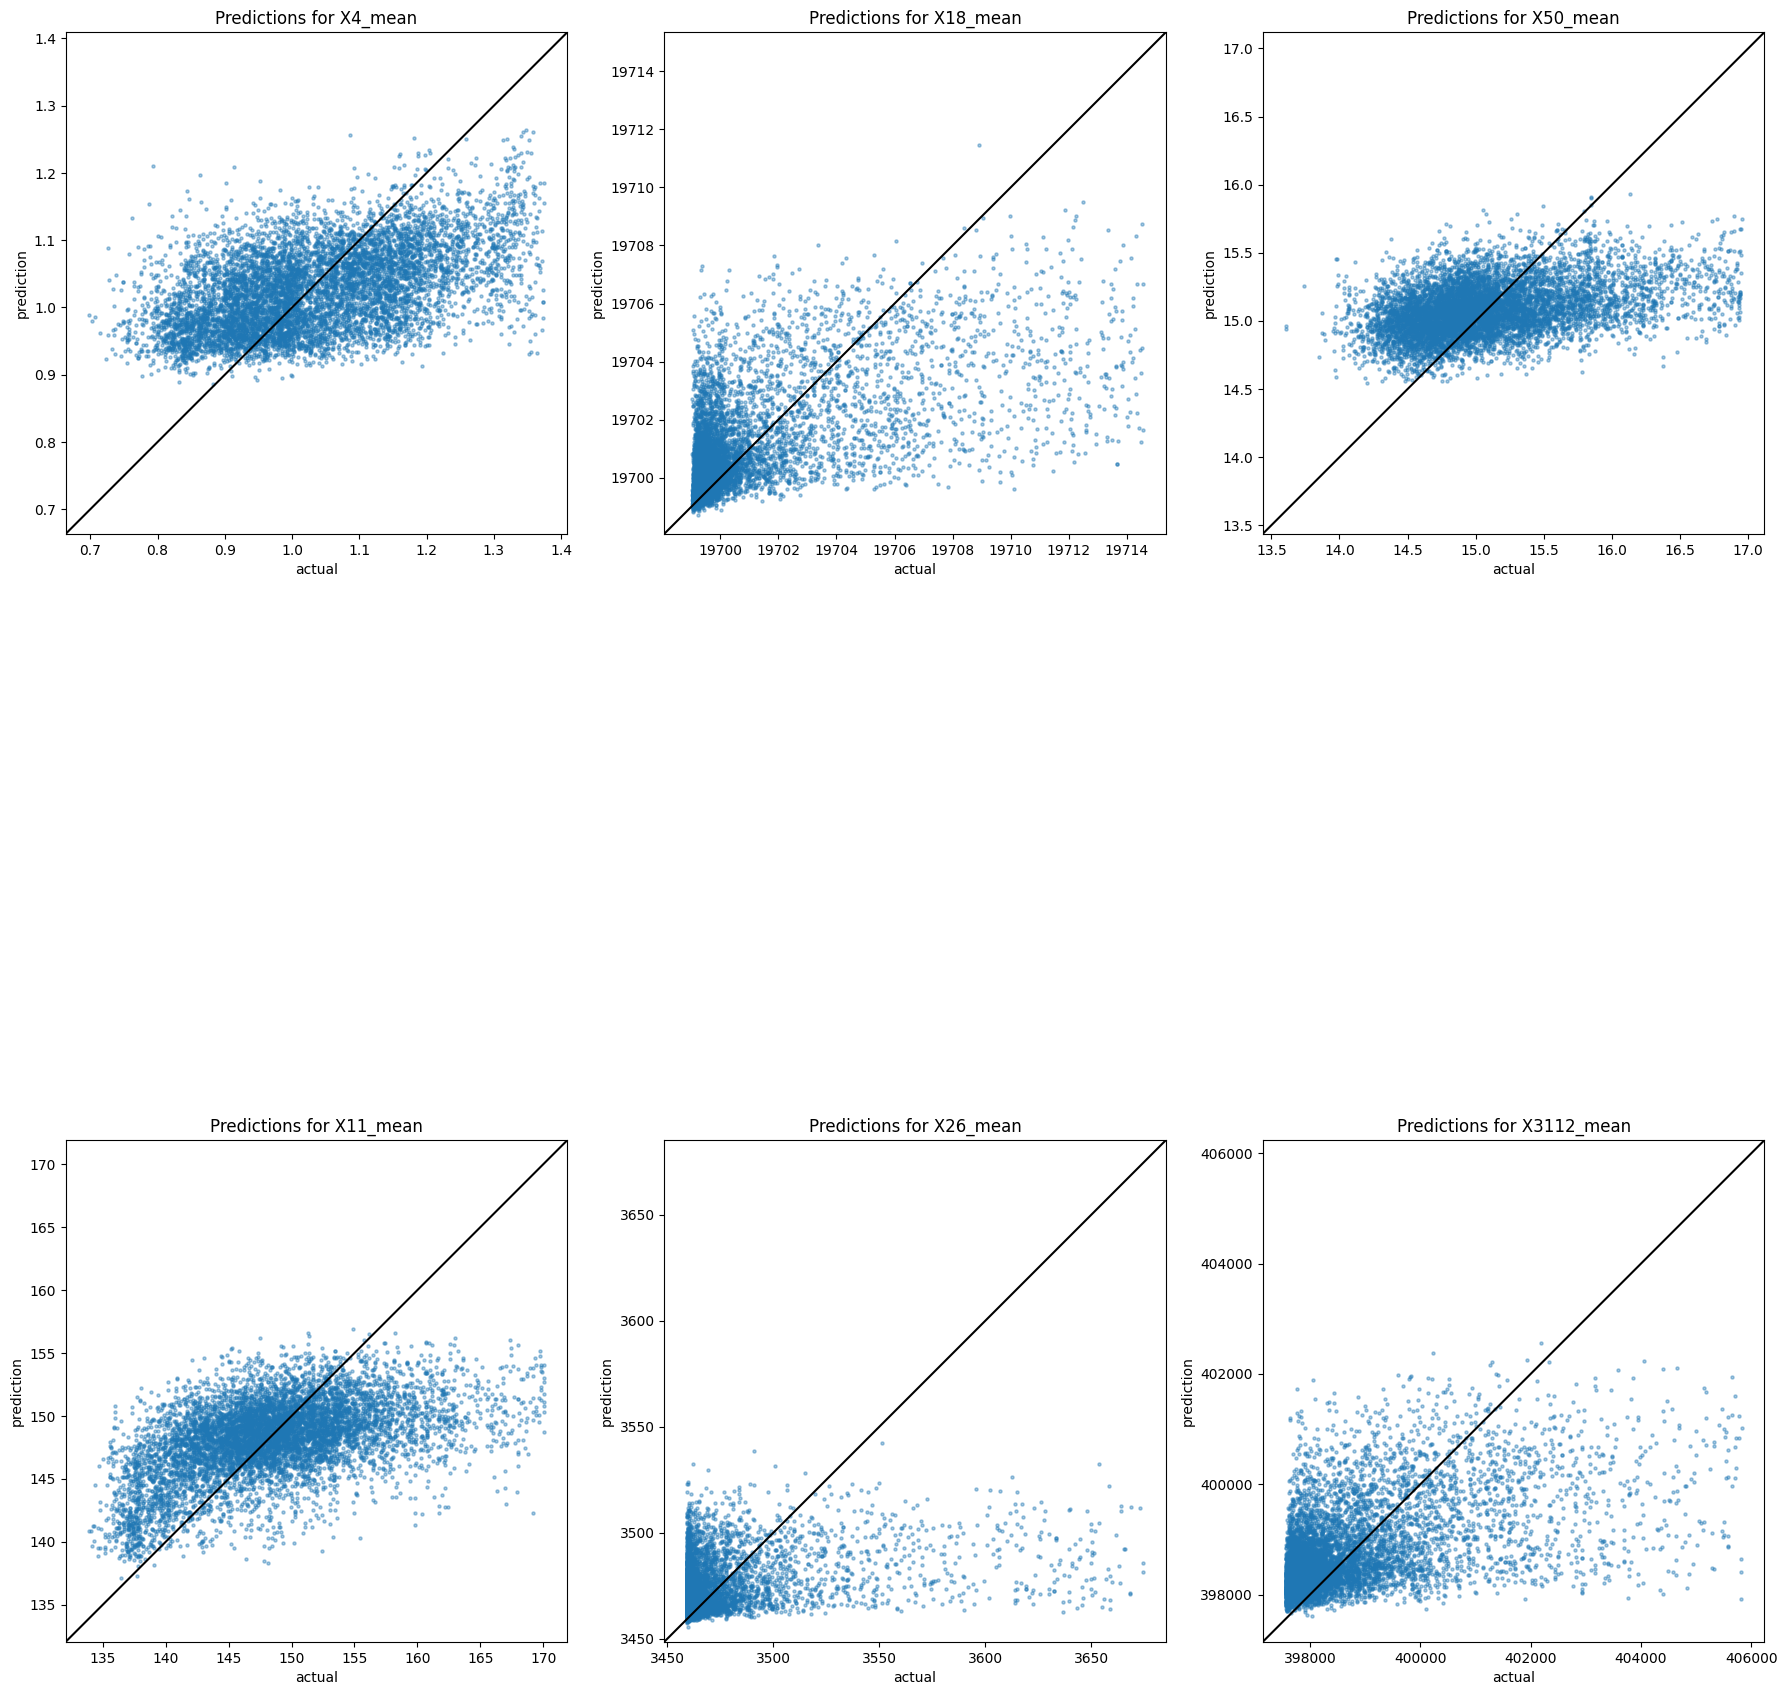

In [19]:
figure, axis = plt.subplots(nrows=2, ncols=3, figsize=(2*9, 3*9))
val = pd.DataFrame(val)
val.columns = LABELS

for i in range(2):
    for j in range(3):
        axis[i, j].set_title(f"Predictions for {val.columns[i+j*2]}")
        axis[i, j].set(ylabel='prediction', xlabel='actual')
        axis[i, j].scatter(y_val.to_numpy()[:, i+j*2], val.to_numpy()[:, i+j*2], alpha=0.4, s=5)
        # now plot both limits against eachother
        lims = [
            np.min([axis[i, j].get_xlim(), axis[i, j].get_ylim()]),  # min of both axes
            np.max([axis[i, j].get_xlim(), axis[i, j].get_ylim()]),  # max of both axes
        ]
        axis[i, j].plot(lims, lims, 'k-')
        axis[i, j].set_aspect('equal')
        axis[i, j].set_xlim(lims)
        axis[i, j].set_ylim(lims)
figure.tight_layout()
plt.savefig('prediction_scatter.png')
plt.show()

In [20]:
predictions = model.predict(x_test)
df = pd.DataFrame(predictions)
df.columns = LABELS
df = min_max_scaler_inverse(df, np.log10(train_label_min), np.log10(train_label_max))
df = 10 ** df
rename = {name1: name2 for name1, name2 in zip(LABELS, OUTPUTS)}
df = df.rename(columns = rename)
df = df[["X4","X11","X18","X26","X50","X3112"]]
df.insert(loc=0, column='id', value=id_test)
df.to_csv("submission.csv", index=False, float_format='%.11f')
print("finished")

finished
